# Testing the optimization run for convergence:

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.factory import (
    get_performance_indicator,
)  # Used to calculate hypervolume from archivelogged solutions

In [2]:
import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

## Hypervolume:

First read the runtime file from the outputs:

In [3]:
seeds = [10, 20, 30, 40, 50]
runtimes = dict()
for seed in seeds:
    with open(
        f"../experimentation/borg_optimization/runtime/runtime_seed_{seed}.txt"
    ) as f:
        runtimes[seed] = f.readlines()

In [6]:
seed_nfe_archives = dict()

for seed in seeds:
    contents = runtimes[seed]

    nfe_archive = dict()

    for i, line in enumerate(contents):

        if line[:5] == "//NFE":

            nfe_count = int(line[6:-1])
            j = i + 1  # With this index, scan lines below //NFE:
            batch_of_this_nfe = list()

            while j < len(contents) and contents[j][:5] != "//NFE":
                batch_of_this_nfe.append(contents[j])
                j += 1

            objective_tuples = []

            for obj_line in batch_of_this_nfe:
                if obj_line[0] == " ":  # This means we are a line with obj values
                    objective_tuples.append(
                        tuple([round(float(x), 2) for x in obj_line.split()])
                    )

            nfe_archive[nfe_count] = objective_tuples
    seed_nfe_archives[seed] = nfe_archive

In [8]:
# latest_archive = nfe_archive[max(nfe_archive.keys())]

best = [
    100,
    0,
    100,
    0,
]  # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0, -190, 0, -20]  # Same idea, initialize the worst as something very good

for seed in seeds:
    nfe_archive = seed_nfe_archives[seed]
    for archive_set in nfe_archive.values():

        for objective_index in range(4):
            obj_values = [solution[objective_index] for solution in archive_set]
            minimum = min(obj_values)
            maximum = max(obj_values)
            if minimum < best[objective_index]:
                best[objective_index] = minimum
            if maximum > worst[objective_index]:
                worst[objective_index] = maximum

In [9]:
print(best)
print(worst)

[0.05, -178.16, 0.0, -14.32]
[7.6, -153.0, 2.78, -8.83]


In [10]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])
        # df[col] = 1 - df[col]

    return np.array(df)

In [9]:
normalize_objs(pd.DataFrame(nfe_archive[136000]), worst, best)

array([[ 0.36746143,  0.00085034, -0.        ,  0.24074074],
       [ 0.43618513,  0.00170068, -0.        ,  0.13148148],
       [ 0.01823282,  0.14158163, -0.        ,  0.24259259],
       ...,
       [ 0.26367461,  0.06802721, -0.        ,  0.04259259],
       [ 0.12201964,  0.05569728, -0.        ,  0.2       ],
       [ 0.13323983,  0.05952381, -0.        ,  0.16481481]])

In [11]:
from tqdm import tqdm

hypervolumes = dict()
for seed in seeds:
    nfe_archive = seed_nfe_archives[seed]

    # Let's calculate hypervolume per NFE to plot
    hvs = []

    hv = get_performance_indicator(
        "hv", ref_point=np.array([1.2, 1.2, 1.2, 1.2])
    )  # Reference set, works fine since everything is btwn 0-1

    for keys, values in tqdm(nfe_archive.items()):

        # print(i, "I am here NFE")
        hvs.append(hv.do(normalize_objs(pd.DataFrame(values), worst, best)))
        # print(i, "I am here HV")
    hypervolumes[seed] = hvs

100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


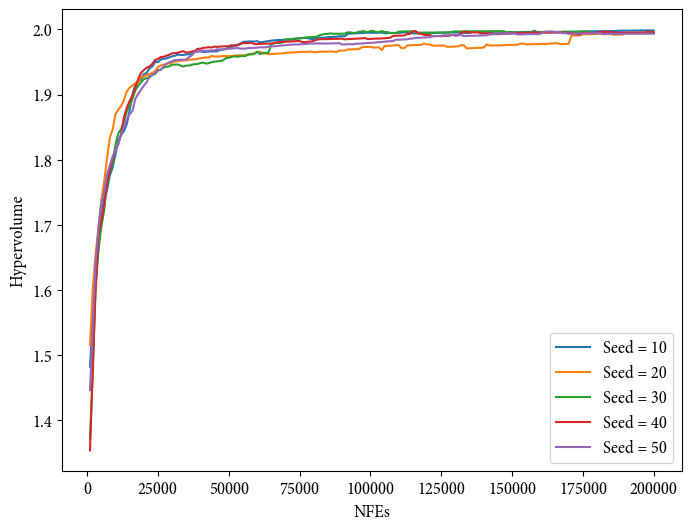

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("NFEs")
ax.set_ylabel("Hypervolume")
for seed in seeds:
    hvs = hypervolumes[seed]
    nfe_archive = seed_nfe_archives[seed]
    ax.plot(
        list(nfe_archive.keys()), hvs, label=f"Seed = {seed}"
    )  # First 6 distorts the view, giving a wrong sense of convergence
ax.legend()
plt.savefig("../plots/baseline_optimization/hypervolume.pdf")
plt.show()